In [1]:
import pandas as pd
from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor
import matplotlib.pyplot as plt

****
# Initial Processing
****

- For conflict detection, we just have a start marker because the detection itself is a very short moment. It is probably scanning befaire the actual task execution. How to measure it ?
- rgd speed vector does not have a start and end because it's when the ATCO clicked on the speed vector. Not a task itself but often the start of conflict resolution process. It is and additional HMI information. 

In [7]:
ms_data_path = "/store/kruu/eye_tracking/ms_dataset/Project1 Data export raw_001.tsv"
atco_data_path =  "/store/kruu/eye_tracking/atco_hungary/wholeHungary_gaze_data_glasses.tsv"

df_ms = pd.read_csv(ms_data_path, sep='\t')
df_atco = pd.read_csv(atco_data_path, sep='\t')

# Session is not a task
# Conflict detection is only start. Find a way to measure it. 
atco_tasks = [
    event for event in df_atco.Event.unique()
    if (
        isinstance(event, str)
        and " - " in event
        and (event.endswith("start") or event.endswith("end"))
        and not event.startswith("Session -")
        and not event.startswith("Conflict detection -")
    )
]

# Mapping like Tasks were defined in ms_df
def map_events_to_tasks_inplace(df, event_column, task_events):
    task_roots = sorted(set(event.split(" - ")[0] for event in task_events if " - " in event))
    root_to_task = {root: f"Task {i+1}" for i, root in enumerate(task_roots)}

    def map_event(event):
        if isinstance(event, str) and " - " in event:
            root, suffix = event.split(" - ", maxsplit=1)
            task_label = root_to_task.get(root)
            if task_label:
                return task_label if suffix == "start" else f"{task_label} end"
        return event
    
    df[event_column] = df[event_column].apply(map_event)
    return root_to_task

atco_tasks_map = map_events_to_tasks_inplace(df_atco, "Event", atco_tasks)

atco_tasks_mapped = [f"Task {i+1}" for i in range(len(atco_tasks)//2)]
ms_tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', 'Event']

/tmp/ipykernel_369527/3633154795.py:4: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ms = pd.read_csv(ms_data_path, sep='\t')


In [8]:
atco_tasks_map

{'Aircraft requests': 'Task 1',
 'Conflict resolution': 'Task 2',
 'Coordination response': 'Task 3',
 'QoS': 'Task 4',
 'Return to route': 'Task 5',
 'assume': 'Task 6',
 'transfer': 'Task 7'}

In [4]:
df_atco.Event.value_counts()

Event
MouseEvent                       2626
Task 6                             17
Task 6 end                         17
Task 5 end                         13
Task 5                             13
Task 7 end                         11
Task 7                             11
Task 2                             10
Task 2 end                         10
speed vector change                 6
Task 1 end                          2
Conflict detection - start          2
Task 1                              2
TextStart                           1
TextEnd                             1
ScreenRecordingStart                1
Session - start                     1
RecordingStart                      1
ParticipantAudioStart               1
Eye tracker Calibration start       1
Eye tracker Calibration end         1
Task 3                              1
Task 3 end                          1
Task 4                              1
Task 4 end                          1
Session - end                       1
Screen

## Things to watchout for:
- Some tasks might be contained within other tasks. -> Try to detect them. 
- Event speed vector change is an HMI information, not a task
- No columns participant name.
- Column names have now the units -> names have changed
- recording timestamp in ms and not microseconds.
- Task range can account for overlapping tasks but only one active instance per task type:
    - Task 1 start Task 2 start Task 2 end Task 1 end -> OK
    - Task 1 start Task 1 start Task 1 end Task 1 end -> NOT OK because will overwrite the first Task 1
    - New version can handle overlapping of the same task bu assume that the current end is mattched with the most recent unmatched start
    - For overlaps of different tasks, task_range_finder old and news are the same.
- Is it really realistic that we can have overlapping tasks? Can one specific gaze observation be associated with two tasks really ? 
    - Old get_feature function doesn't handle overlapping task. One observation is associated to only one task.
    - New get_features function handle it by outputing a dict whose key is the task id, and the value the corresponding chunk of the dataframe. 
    - For real-time implementation, do the same with fixed size chunks (ex 3s), ans assign the mos present task during those 3s.
    - The problem with overlapping is that we can have label leakage, and therefore one observation can be used to classify 2 different tasks. We really have to discuss it together. 

In [5]:
processor = EyeTrackingProcessor()
task_ranges_old = processor.task_range_finder_old(df_atco)
print("")
task_ranges = processor.task_range_finder(df_atco)
print("")
chunks_raw = processor.get_features([df_atco], features)


In [6]:
chunks_raw["0_6_0"]

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X [DACS px],Mouse position Y [DACS px],Event,Task_id,Task_execution,Participant name,id
12439,93608,NaN,NaN,NaN,NaN,Task 6,6,0,0,0_6_0
12440,93611,863.0,903.0,NaN,NaN,NaN,6,0,0,0_6_0
12441,93620,869.0,903.0,NaN,NaN,NaN,6,0,0,0_6_0
12442,93628,864.0,905.0,NaN,NaN,NaN,6,0,0,0_6_0
12443,93636,870.0,910.0,NaN,NaN,NaN,6,0,0,0_6_0
...,...,...,...,...,...,...,...,...,...,...
13128,98928,769.0,859.0,NaN,NaN,NaN,6,0,0,0_6_0
13129,98936,861.0,770.0,NaN,NaN,NaN,6,0,0,0_6_0
13130,98944,854.0,766.0,NaN,NaN,NaN,6,0,0,0_6_0
13131,98953,776.0,746.0,NaN,NaN,NaN,6,0,0,0_6_0


In [7]:
def find_overlapping_or_nested_tasks(task_dict):
    overlaps = []
    nested = []

    # Step 1: Flatten intervals into (task, start, end)
    intervals = []
    for task, ranges in task_dict.items():
        for start, end in ranges:
            intervals.append((task, start, end))

    # Step 2: Sort by start time
    intervals.sort(key=lambda x: x[1])  # sort by start

    # Step 3: Compare each interval to the rest
    for i in range(len(intervals)):
        task1, start1, end1 = intervals[i]
        for j in range(i + 1, len(intervals)):
            task2, start2, end2 = intervals[j]

            # Skip if it's the same task (optional)
            if task1 == task2:
                continue

            if start2 < end1:
                overlaps.append(((task1, start1, end1), (task2, start2, end2)))
                if start2 >= start1 and end2 <= end1:
                    nested.append(((task1, start1, end1), (task2, start2, end2)))
            else:
                break  # since sorted by start, no need to check further

    return overlaps, nested

find_overlapping_or_nested_tasks(task_ranges)

([(('Task 2', 90765, 117482), ('Task 6', 93608, 98955)),
  (('Task 2', 90765, 117482), ('Task 6', 107411, 112261)),
  (('Task 2', 90765, 117482), ('Task 6', 116986, 118976)),
  (('Task 2', 190065, 204030), ('Task 6', 203356, 206522)),
  (('Task 6', 731461, 756264), ('Task 2', 743326, 754166)),
  (('Task 2', 855543, 861230), ('Task 3', 855543, 883670)),
  (('Task 2', 855543, 861230), ('Task 6', 858442, 886562)),
  (('Task 3', 855543, 883670), ('Task 6', 858442, 886562)),
  (('Task 6', 858442, 886562), ('Task 2', 885919, 906395)),
  (('Task 7', 1013243, 1034837), ('Task 6', 1033778, 1045970)),
  (('Task 6', 1033778, 1045970), ('Task 7', 1041538, 1054445)),
  (('Task 7', 1041538, 1054445), ('Task 6', 1052301, 1059005)),
  (('Task 2', 1168890, 1180852), ('Task 7', 1180035, 1188722))],
 [(('Task 2', 90765, 117482), ('Task 6', 93608, 98955)),
  (('Task 2', 90765, 117482), ('Task 6', 107411, 112261)),
  (('Task 6', 731461, 756264), ('Task 2', 743326, 754166))])

****
# PLot Raw Data
****

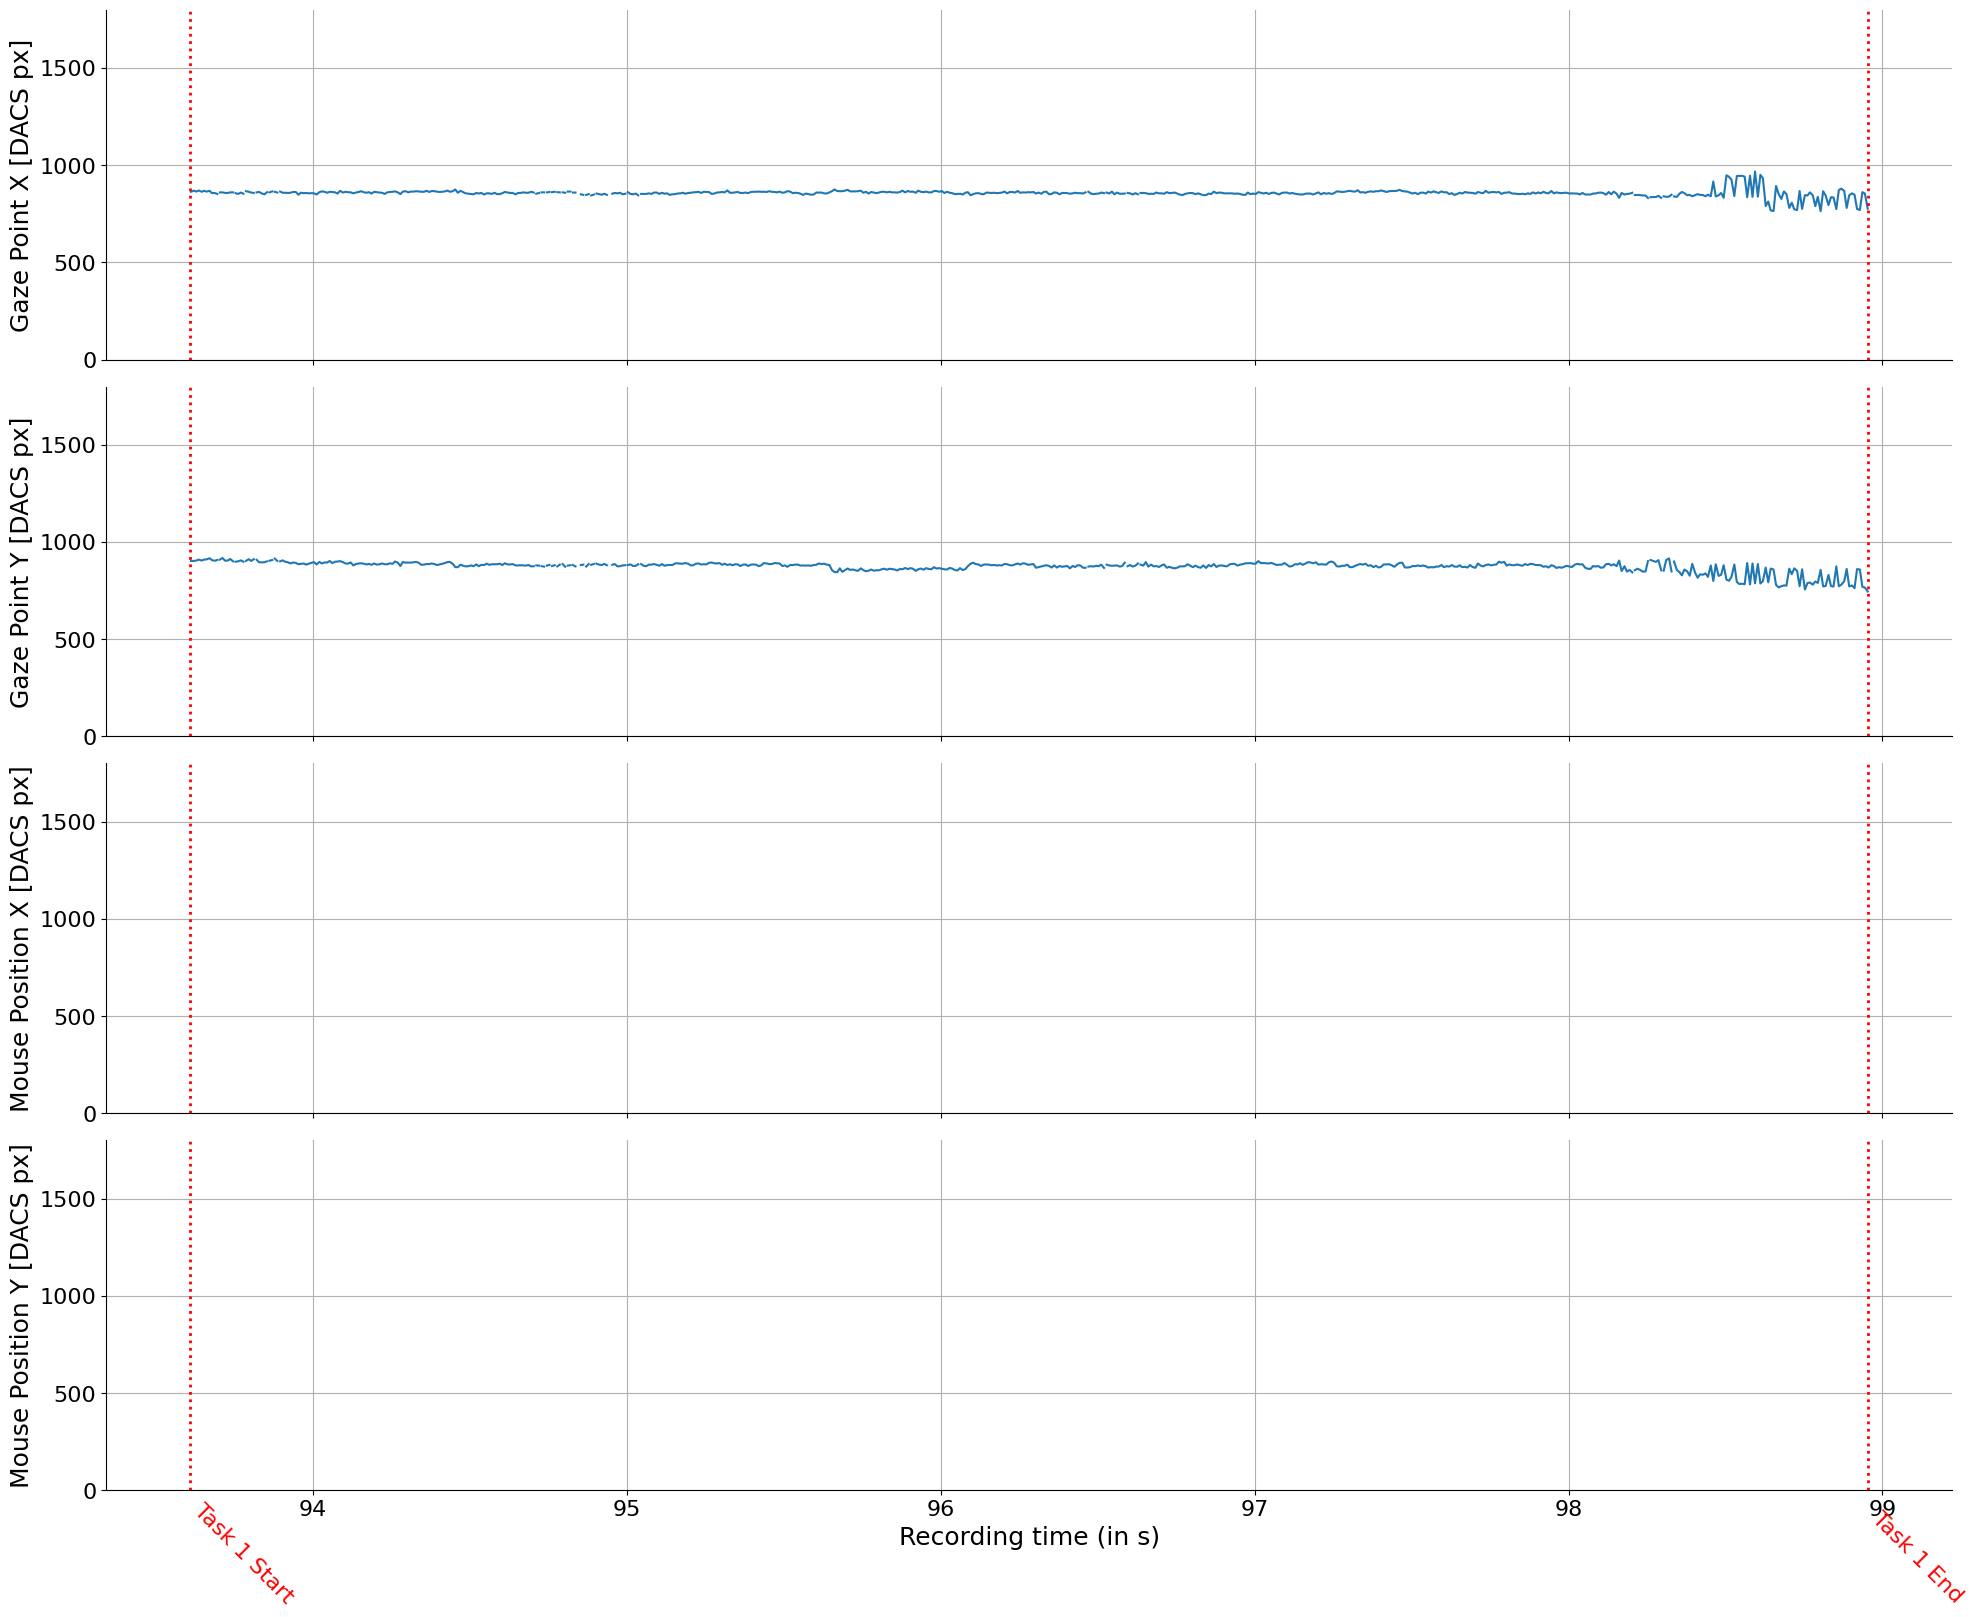

In [8]:
id_task = "0_6_0"
task_plot = chunks_raw[id_task]

fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3
start_time_sec = task_plot.iloc[0]["Recording timestamp [ms]"] / 1e3
end_time_sec = task_plot.iloc[-1]["Recording timestamp [ms]"] / 1e3

# Titles for each subplot
titles = ['Gaze Point X [DACS px]', 'Gaze Point Y [DACS px]', 'Mouse Position X [DACS px]', 'Mouse Position Y [DACS px]']
data_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

# Plot each subplot
for ax, title, col in zip(axs, titles, data_columns):
    ax.plot(timestamps_sec, task_plot[col], label=title)
    ax.axvline(x=start_time_sec, color='red', linestyle=':', linewidth=2)
    ax.axvline(x=end_time_sec, color='red', linestyle=':', linewidth=2)
    ax.set_ylim(0, 1800)
    ax.set_ylabel(title)
    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Add labels directly to vertical lines on the top subplot only
axs[-1].text(start_time_sec, -600, 'Task 1 Start', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)
axs[-1].text(end_time_sec, -600, 'Task 1 End', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)

# X-axis label on the last subplot
axs[-1].set_xlabel('Recording time (in s)', fontsize = 18)

for ax in axs:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

****
# Blink detection
****

Note: 
- Blink id are note necessrily consecutive because we can have missing gaze values that are not long enough to constitute a blink 

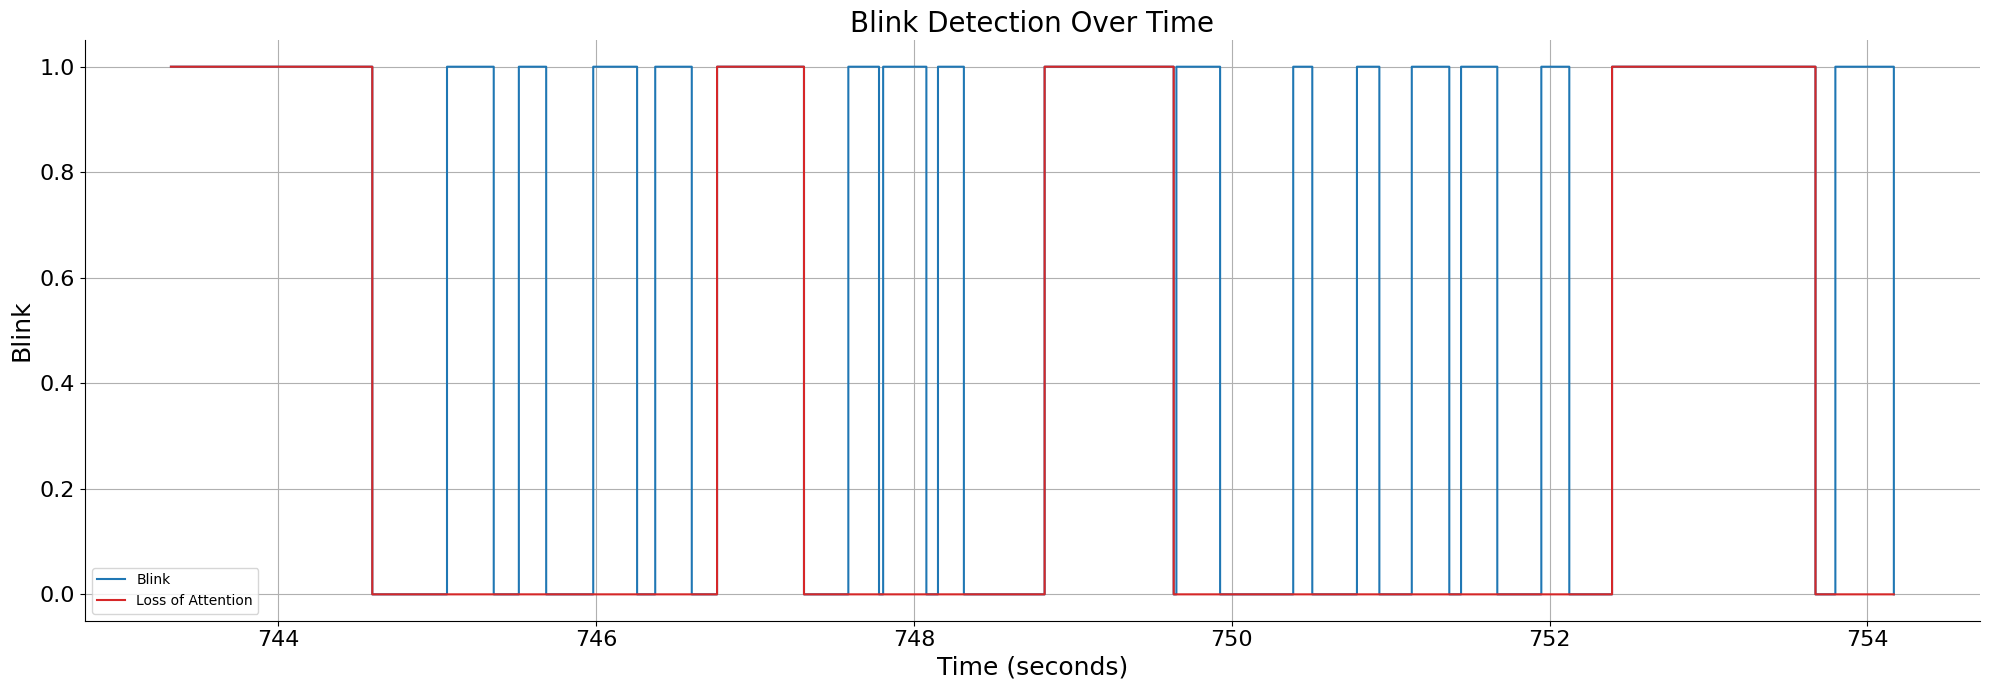

In [9]:
chunks, blinks = processor.detect_blinks(chunks_raw)

task_plot = chunks['0_2_2']

fig, ax = plt.subplots(1, 1, figsize=(20, 7), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3

ax.step(timestamps_sec, task_plot["Blink"], label="Blink", where="post", color='tab:blue')
ax.step(timestamps_sec, task_plot["Loss of Attention"], label="Loss of Attention", where="post", color='tab:red')
ax.set_ylabel("Blink", fontsize=18)
ax.set_xlabel("Time (seconds)", fontsize=18)
ax.set_title("Blink Detection Over Time", fontsize=20)
ax.grid(True)
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()

In [10]:
blinks['0_2_2']

,Blink ID,Time Diff,Attention State,Loss of Attention
0,1,1259.0,Loss of attention,True
22,23,292.0,Blink,False
33,34,175.0,Blink,False
51,52,275.0,Blink,False
59,60,234.0,Blink,False
70,71,542.0,Loss of attention,True
86,87,192.0,Blink,False
88,89,275.0,Blink,False
94,95,158.0,Blink,False
123,124,809.0,Loss of attention,True


- Blink if between 100ms and 400ms. If longer, it's a loss of attention. If lower, it's not considered.

****
# Interpolated Data + XGBoost processing 
****

In [11]:
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']
for task_id, chunk in chunks.items():
    for col in fill_columns:
        chunks[task_id][col] = chunks[task_id][col].ffill().bfill()

In [21]:
# Manual feature extraction

gaze_metrics = []
mouse_metrics = []
for task_id, chunk in chunks.items():
    gaze_processor = GazeMetricsProcessor(chunk, timestamp_unit="ms")
    gaze_compute = gaze_processor.compute_all_metrics()
    gaze_compute.update({"id": task_id})
    gaze_metrics.append(gaze_compute)
    
    mouse_processor = MouseMetricsProcessor(chunk, timestamp_unit="ms")
    mouse_compute = mouse_processor.compute_all_metrics()
    mouse_compute.update({"id": task_id})
    mouse_metrics.append(mouse_compute)
gaze_metrics_df = pd.DataFrame(gaze_metrics)
mouse_metrics_df = pd.DataFrame(mouse_metrics)


In [ ]:
# TS fresh
columns_to_extract = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

# The chunks were bfill and ffill before. Of course there are very few zeros.
def drop_chunks_with_all_zero_features(task_chunks: dict[str, pd.DataFrame], threshold: float = 1.0) -> dict[str, pd.DataFrame]:
    """
    Drops any DataFrame from the dict where at least one feature column has a great proportion of zero.
    
    Parameters
    ----------
    task_chunks : dict[str, pd.DataFrame]
        Dictionary with task ID as key and task data as value.
    threshold: float
        Proportion of zeros required to drop a feature
    
    Returns
    -------
    dict[str, pd.DataFrame]
        Filtered dictionary with problematic chunks removed.
    """
    feature_cols = ["Gaze point X", "Gaze point Y", "Mouse position X", "Mouse position Y"]
    cleaned_chunks = {}
    dropped_ids = []
    for task_id, df in task_chunks.items():
            present_cols = [col for col in feature_cols if col in df.columns]
            drop = False

            for col in present_cols:
                zero_ratio = (df[col] == 0).mean()  # proportion of zeros
                if zero_ratio >= threshold:
                    drop = True
                    break

            if drop:
                dropped_ids.append(task_id)
            else:
                cleaned_chunks[task_id] = df

    if dropped_ids:
        print(f"Dropped {len(dropped_ids)} chunks (threshold={threshold}):", dropped_ids)
    else:
        print(f"No chunks dropped (threshold={threshold}).")

    return cleaned_chunks

cleaned_task_chunks = drop_chunks_with_all_zero_features(chunks, threshold=0.95)

No chunks dropped (threshold=0.95).


In [34]:
full_df = pd.concat(cleaned_task_chunks.values(), ignore_index=True)

In [35]:
full_df

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X [DACS px],Mouse position Y [DACS px],Event,Task_id,Task_execution,Participant name,id,Blink,Loss of Attention
0,93608,863.0,903.0,865.0,868.0,Task 6,6,0,0,0_6_0,0,False
1,93611,863.0,903.0,865.0,868.0,NaN,6,0,0,0_6_0,0,False
2,93620,869.0,903.0,865.0,868.0,NaN,6,0,0,0_6_0,0,False
3,93628,864.0,905.0,865.0,868.0,NaN,6,0,0,0_6_0,0,False
4,93636,870.0,910.0,865.0,868.0,NaN,6,0,0,0_6_0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
130351,1686913,805.0,522.0,-3674.0,343.0,NaN,4,0,0,0_4_0,0,False
130352,1686921,811.0,526.0,-3674.0,343.0,NaN,4,0,0,0_4_0,0,False
130353,1686929,807.0,521.0,-3674.0,343.0,NaN,4,0,0,0_4_0,0,False
130354,1686938,807.0,521.0,-3674.0,343.0,NaN,4,0,0,0_4_0,0,False


In [ ]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import MinimalFCParameters

def detect_timestamp_column(df: pd.DataFrame) -> str:
    candidates = [col for col in df.columns if "Recording timestamp" in col]
    if not candidates:
        raise ValueError("No 'Recording timestamp' column found.")
    return candidates[0] 

def extract_tsfresh_features_from_chunks(
    task_chunks: dict[str, pd.DataFrame],
    columns_to_extract: list[str],
    pval_threshold: float = 0.05,
    n_jobs: int = 4
) -> pd.DataFrame:
    """
    Extract and select TSFresh features from a dictionary of task chunks.

    Parameters:
    - task_chunks: dict with `id` as key and corresponding df as value
    - columns_to_extract: list of features to use in TSFresh
    - pval_threshold: p-value threshold for relevance filtering
    - n_jobs: number of parallel jobs for TSFresh

    Returns:
    - final_features: DataFrame of filtered, selected features with `id` as index
    """
    # Step 1: Recombine into one DataFrame
    # Rows are dupplicated if we have overlapping tasks
    full_df = pd.concat(task_chunks.values(), ignore_index=True)
    timestamp_col = detect_timestamp_column(full_df)

    # Step 2: Run TSFresh
    print("Extracting TSFresh features...")
    extracted_features = extract_features(
        full_df[["id", timestamp_col] + columns_to_extract],
        column_id="id",
        column_sort=timestamp_col,
        default_fc_parameters=MinimalFCParameters(), 
        n_jobs=n_jobs,
        disable_progressbar=False
    )

    # Step 3: Impute missing features
    impute(extracted_features)

    # Step 4: Define target variable (from original task chunks)
    task_labels = full_df.groupby("id")["Task_id"].first()

    # Step 5: Relevance filtering
    relevant_features = calculate_relevance_table(extracted_features, task_labels)
    selected_features = relevant_features[relevant_features["p_value"] < pval_threshold]["feature"]
    
    # Step 6: Final filtered feature matrix
    final_features = extracted_features[selected_features].reset_index(names="id")

    return final_features

tsfresh_data = extract_tsfresh_features_from_chunks(cleaned_task_chunks, columns_to_extract, pval_threshold=0.05, n_jobs=50)


Extracting TSFresh features...


Feature Extraction: 100%|██████████| 220/220 [00:00<00:00, 1600.07it/s]


In [44]:
xgboost_data = gaze_metrics_df.merge(mouse_metrics_df, on="id")
xgboost_data = xgboost_data.merge(tsfresh_data, on="id")

Now test if training happens smoothly

****
# JCAFNET Processing
****

In [14]:
import numpy as np
import os
from tqdm import tqdm
from typing import Union, Dict, Tuple
from pathlib import Path

In [9]:
data_path = "/store/kruu/eye_tracking/atco_hungary"
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X [DACS px]', 'Mouse position Y [DACS px]']

def load_and_process(data_path: Union[str, Path],
                     columns: list[str],
                     interpolate_cols: list[str],
                     fill_cols: list[str]
                     ) -> pd.DataFrame:
    
    files_list = os.listdir(data_path)
    files_list = [os.path.join(data_path, file) for file in files_list if file.endswith(".tsv")]
    
    processor = EyeTrackingProcessor()
    all_data, _ = processor.load_data(files_list)
    chunks = processor.get_features(all_data, columns)
    chunks, blinks = processor.detect_blinks(chunks)
    
    # Fixed Time step resampling
    resampled_chunks_time = processor.resample_task_chunks(chunks, interpolate_cols, mode="time", param=10)

    for task_id, chunk in resampled_chunks_time.items():
        resampled_chunks_time[task_id].Blink = (resampled_chunks_time[task_id].Blink > 0.5) #Transform interpolated data
        for col in fill_cols:
            resampled_chunks_time[task_id][col] = resampled_chunks_time[task_id][col].ffill().bfill()
        
    return resampled_chunks_time

chunks = load_and_process(data_path, features, interpolate_cols, fill_columns)

In [15]:
def compute_joint_features(df:pd.DataFrame):
    gaze_x = next((col for col in df.columns if "Gaze point X" in col), None)
    gaze_y = next((col for col in df.columns if "Gaze point Y" in col), None)
    mouse_x = next((col for col in df.columns if "Mouse position X" in col), None)
    mouse_y = next((col for col in df.columns if "Mouse position Y" in col), None)
    
    gx, gy = df[gaze_x].fillna(0), df[gaze_y].fillna(0)
    mx, my = df[mouse_x].fillna(0), df[mouse_y].fillna(0)

    distance = np.sqrt((gx - mx)**2 + (gy - my)**2)
    angle = np.arctan2(gy - my, gx - mx)  # radians
    return distance, angle

#Enrich dataframe with features for JCAFNet
def enrich_with_gaze_mouse_metrics(task_chunks: dict[str, pd.DataFrame]) -> dict[str, pd.DataFrame]:
    enriched_chunks = {}

    for task_id, df in tqdm(task_chunks.items(), desc="Enriching features"):
        df = df.copy()

        # Initialize metrics columns
        df["Gaze Velocity"] = np.nan
        df["Gaze Acceleration"] = np.nan
        df["Mouse Velocity"] = np.nan
        df["Mouse Acceleration"] = np.nan
        df["Gaze-Mouse Distance"] = np.nan
        df["Angle Between Gaze and Mouse"] = np.nan

        # Gaze metrics
        gaze_proc = GazeMetricsProcessor(df)
        gaze_vel, gaze_acc = gaze_proc.compute_velocity_acceleration()
        df["Gaze Velocity"] = gaze_vel.fillna(0).values
        df["Gaze Acceleration"] = gaze_acc.fillna(0).values

        # Mouse metrics
        mouse_proc = MouseMetricsProcessor(df)
        mouse_vel, mouse_acc = mouse_proc.compute_velocity_acceleration()
        df["Mouse Velocity"] = mouse_vel.fillna(0).values
        df["Mouse Acceleration"] = mouse_acc.fillna(0).values

        # Joint gaze-mouse features
        dist, angle = compute_joint_features(df)
        df["Gaze-Mouse Distance"] = dist.fillna(0).values
        df["Angle Between Gaze and Mouse"] = angle.fillna(0).values

        enriched_chunks[task_id] = df

    return enriched_chunks


enriched_chunks = enrich_with_gaze_mouse_metrics(chunks)

Enriching features: 100%|██████████| 55/55 [00:00<00:00, 132.87it/s]


In [17]:
enriched_chunks["0_2_1"]

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X [DACS px],Mouse position Y [DACS px],Blink,id,Participant name,Task_id,Task_execution,Gaze Velocity,Gaze Acceleration,Mouse Velocity,Mouse Acceleration,Gaze-Mouse Distance,Angle Between Gaze and Mouse
0,190065,721.125000,744.000000,-4142.0,685.0,True,0_2_1,0,2,1,0.000000,0.000000,0.0,0.0,4863.482884,0.012132
1,190075,721.125000,744.000000,-4142.0,685.0,True,0_2_1,0,2,1,0.000000,0.000000,0.0,0.0,4863.482884,0.012132
2,190085,720.000000,742.000000,-4142.0,685.0,True,0_2_1,0,2,1,229.469497,22946.949688,0.0,0.0,4862.334110,0.011723
3,190095,716.750000,745.500000,-4142.0,685.0,True,0_2_1,0,2,1,477.624329,24815.483248,0.0,0.0,4859.126651,0.012451
4,190105,726.666667,746.111111,-4142.0,685.0,True,0_2_1,0,2,1,993.547858,51592.352841,0.0,0.0,4869.050182,0.012551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,203985,1121.000000,736.000000,-4012.0,663.0,True,0_2_1,0,2,1,500.624610,-86210.472863,0.0,0.0,5133.519066,0.014221
1393,203995,1117.250000,739.750000,-4012.0,663.0,True,0_2_1,0,2,1,530.330086,2970.547603,0.0,0.0,5129.824181,0.014962
1394,204005,1113.333333,742.555556,-4012.0,663.0,True,0_2_1,0,2,1,481.782313,-4854.777246,0.0,0.0,5125.950728,0.015521
1395,204015,1109.375000,743.250000,-4012.0,663.0,True,0_2_1,0,2,1,401.878786,-7990.352742,0.0,0.0,5122.003705,0.015668


# Train / Test / Val split based on participant

Doesn't work yet because we only have hone participant

In [ ]:
from sklearn.model_selection import train_test_split

def split_chunks_by_participant(
    chunks: dict[str, pd.DataFrame],
    val_split=0.2,
    test_split=0.1,
    random_state=42
) -> tuple[dict[str, pd.DataFrame], dict[str, pd.DataFrame], dict[str, pd.DataFrame]]:
    """
    Split a dictionary of task chunks into train, val, and test sets by participant.

    Parameters:
        chunks: dict[str, pd.DataFrame] - key = ID, value = task dataframe
        val_split: proportion of participants for validation set
        test_split: proportion of participants for test set
        random_state: reproducibility

    Returns:
        train_chunks, val_chunks, test_chunks as dictionaries
    """

    # Step 1: Map each chunk to its participant
    id_to_participant = {
        task_id: df["Participant name"].iloc[0] for task_id, df in chunks.items()
    }
    all_participants = list(set(id_to_participant.values()))

    # Step 2: Split participants
    train_participants, temp_participants = train_test_split(
        all_participants, test_size=(val_split + test_split), random_state=random_state
    )
    relative_val_split = val_split / (val_split + test_split)
    val_participants, test_participants = train_test_split(
        temp_participants, test_size=(1 - relative_val_split), random_state=random_state
    )

    # Step 3: Partition chunks by participant membership
    train_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in train_participants
    }
    val_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in val_participants
    }
    test_chunks = {
        task_id: df for task_id, df in chunks.items()
        if id_to_participant[task_id] in test_participants
    }

    return train_chunks, val_chunks, test_chunks

train_chunks, val_chunks, test_chunks = split_chunks_by_participant(enriched_chunks)